# HW6 SNGAN

Resource:

- https://speech.ee.ntu.edu.tw/~hylee/ml/2021-spring.php

- https://arxiv.org/pdf/1704.00028.pdf

Structure:

- Colab (Do this block if is running on `Colab`)

- Dataset & Dataloader

- Model

- Training

- Inference

# Colab

Mount drive and extract data.

## Data

In [ ]:
import os
os.makedirs('/content/data', exist_ok=True)

from google.colab import drive
drive.mount('/content/drive')

import shutil
shutil.copyfile('/content/drive/MyDrive/ML2021/hw6/data/crypko_data.zip','/content/data/crypko_data.zip')

import zipfile
with zipfile.ZipFile('/content/data/crypko_data.zip','r') as zip_ref:
  zip_ref.extractall('/content/data/')

## Package

In [ ]:
!pip install qqdm

# Dataset/Dataloader

## Dataset

1. Resize images to (64, 64).
2. Linearly map values from [0, 1] to [-1, 1].

In [ ]:
import os
import glob
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset


class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.n_samples = len(self.fnames)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        # load image
        img = torchvision.io.read_image(fname)
        # image transform
        img = self.transform(img)
        return img
    
    def __len__(self):
        return self.n_samples
    
def get_dataset(root):
    # get paths of images
    fnames = glob.glob(os.path.join(root, "*"))
    compose = [
        v2.ToPILImage(),
        # 1. Resize image to (64, 64)
        v2.Resize((64, 64)),
        # map values to [0, 1]
        v2.ToTensor(),
        # 2. Linearly map values to [-1, 1]
        v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]
    transform = v2.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset


### Show Some Images

In [ ]:
import matplotlib.pyplot as plt

dataset = get_dataset("./data/faces")

print("values in [-1, 1]:")
images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1,2,0))
plt.show()

print("values in [0, 1]:")
images_origin = [(dataset[i]+1)/2 for i in range(16)]
grid_img_origin = torchvision.utils.make_grid(images_origin, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img_origin.permute(1,2,0))
plt.show()

## Dataloader

In [22]:
from torch.utils.data import DataLoader


def get_dataloader(dataset, batch_size, n_workers):
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers
    )
    return dataloader

# Model

`N` of the input/output shape stands for batch size.

## Spectral Normalisation

- Reference:

    https://paperswithcode.com/method/spectral-normalization#:~:text=Spectral%20Normalization%20is%20a%20normalization,hyper%2Dparameter%20to%20be%20tuned.

- Code:

    https://github.com/christiancosgrove/pytorch-spectral-normalization-gan/blob/12dcf945a6359301d63d1e0da3708cd0f0590b19/spectral_normalization.py#L14

In [43]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.linalg import vector_norm


def l2normalize(v, eps=1e-12):
    return v / (vector_norm(v) + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iteration=1):
        super().__init__()

        self.module = module
        self.name = name
        self.power_iteration = power_iteration
        if not self._made_params():
            self._make_params()
            self._update_u_v()

    def _update_u_v(self):
        u = getattr(self.module, self.name + '_u')
        v = getattr(self.module, self.name + '_v')
        w = getattr(self.module, self.name + '_bar')

        height = w.shape[0]
        for _ in range(self.power_iteration):
            v.data = l2normalize(torch.mv(torch.t(w.view(height, -1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height, -1).data, v.data))

        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + '_u')
            v = getattr(self.module, self.name + '_v')
            w = getattr(self.module, self.name + '_bar')
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.shape[0]
        width = w.view(height, -1).shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)

        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + '_u', u)
        self.module.register_parameter(self.name + '_v', v)
        self.module.register_parameter(self.name + '_bar', w_bar)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)


## Generator & Discriminator

In [44]:
import torch.nn as nn

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0.0)

class Generator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super().__init__()

        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU()
            )
        
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y
    

class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, model_type : str, dim=64):
        super().__init__()

        def conv_sn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                SpectralNorm(nn.Conv2d(in_dim, out_dim, 5, 2, 2)),
                nn.LeakyReLU(0.2)
            )
        # K: kernel size, P: padding, S: stride
        # x: (N, C, H, W)
        # after one Conv2d(C, C_out, K, S, P)
        # x: (N, C_out, (H + 2*P - K) // 2 + 1, (W + 2*P - K) // 2 + 1)
        self.ls = nn.Sequential(
            # x: (N, 3, 64, 64)
            conv_sn_lrelu(in_dim, dim),

            # x: (N, dim, 32, 32)
            conv_sn_lrelu(dim, dim * 2),

            # x:(N, dim * 2, 16, 16)
            conv_sn_lrelu(dim * 2, dim * 4),

            # x:(N, dim * 4, 8, 8)
            conv_sn_lrelu(dim * 4, dim * 8),

            # x: (N, dim * 8, 4, 4)
            SpectralNorm(nn.Conv2d(dim * 8, 1, 4)),

            # x: (N, 1, 1, 1)
        )

        self.apply(weights_init)

    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y


# Training

## Tools Kit

Common tools kit.

### Logging

In [25]:
import logging
#import datetime
#from pathlib import Path

def set_logger(log_name : str):
    #"""write log under given log_path"""
    #log_dir = Path("./log")
    #log_dir.mkdir(parents=True, exist_ok=True)
    #log_path = log_dir / f"{datetime.datetime.now().date()}.log"

    logger = logging.getLogger(log_name)
    logger.setLevel(logging.INFO)
    formater_s = logging.Formatter("%(name)s [%(levelname)s] %(message)s")
    #formater_f = logging.Formatter("%(asctime)s - %(name)s [%(levelname)s] %(message)s")
    
    if not logger.handlers:
        ## logging to file
        #file_handler = logging.FileHandler(log_path)
        #file_handler.setFormatter(formater_f)
        #logger.addHandler(file_handler)

        # logging to console
        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(formater_s)
        logger.addHandler(stream_handler)
    
    return logger

### Seed

Fix random seed for reproduction.

In [26]:
import random
import torch
import numpy as np


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

### Device

Get running device.

In [27]:
import torch


def get_device():
    return "cuda" if torch.cuda.is_available() \
      else "mps" if torch.backends.mps.is_available() \
      else "cpu"

### Model Save/Load Handler

In [28]:
import torch

class ModelSaveLoad:
    def __init__(self, path):
        self.path = path

    def save(self, G_state_dict, D_state_dict, epoch):
        torch.save({
            "G_state_dict" : G_state_dict,
            "D_state_dict" : D_state_dict,
            "epoch" : epoch
        }, self.path)

    def load(self):
        """Return checkpoint."""
        return torch.load(self.path)

## Main Function

sngan [INFO] mps is used.
sngan [INFO] Data loaded.
sngan [INFO] New model set.
sngan [INFO] Optimizer set.
sngan [INFO] ================ Start Training ================


   Iters      Elapsed Time      Speed     Loss_D   Loss_G   Epoch  Step         
 1115/1115  00:10:07<00:00:00  1.84it/s  -56.3826  92.7357    1    1115         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_001_sngan.jpg.


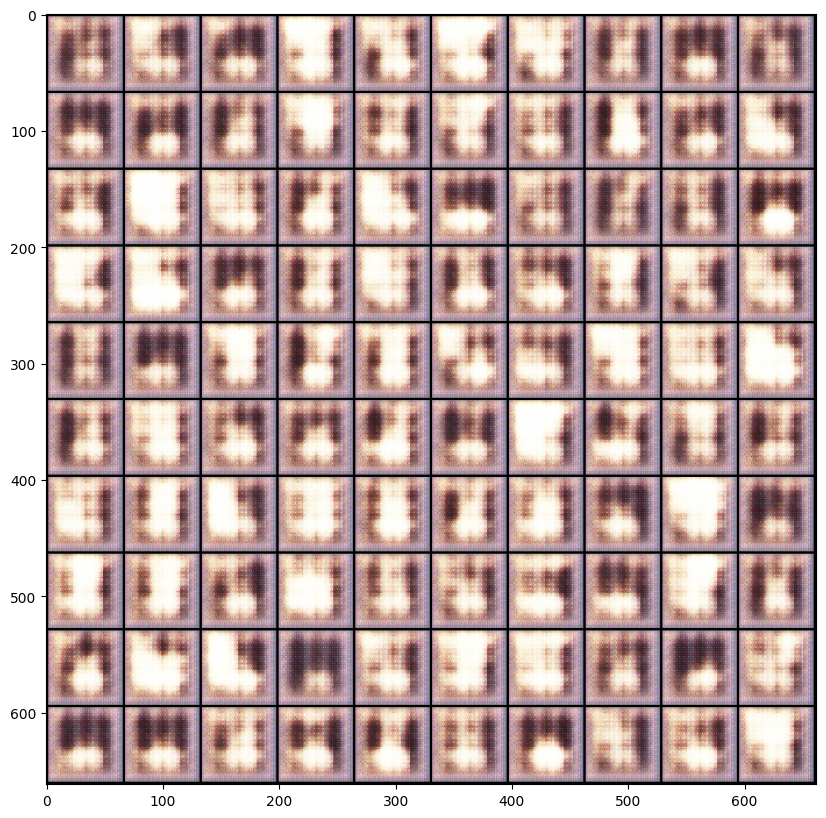

In [45]:
import os
import torch
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm


def parse_args():
    config = {
        "seed": 2021,
        "batch_size": 64,
        "z_dim": 100,
        "n_workers": 0,
        "n_epoch": 1,
        "n_critic": 5,
        "lr": 1e-4,
        "onColab": False,
        "load_ckpt": False,
        "workspace_dir": "./",
        "ckpt_dir_config": {
            "local": "./checkpoints",
            "drive" : "/content/drive/MyDrive/ML2021/hw6/checkpoints"
        },
    }
    return config

def main(
        seed,
        batch_size,
        z_dim,
        n_workers,
        n_epoch,
        n_critic,
        lr,
        ckpt_dir_config,
        onColab,
        load_ckpt,
        workspace_dir
):
    model_type = 'sngan'
    
    logger = set_logger(model_type)

    device = get_device()
    logger.info(f'{device} is used.')

    if onColab:
        ckpt_dir = ckpt_dir_config['drive']
    else:
        ckpt_dir = ckpt_dir_config['local']
    log_dir = os.path.join(workspace_dir, "logs")
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(ckpt_dir, exist_ok=True)

    set_seed(seed)

    # dataset/dataloader
    data_dir = os.path.join(workspace_dir, "data/faces")
    dataset = get_dataset(data_dir)
    dataloader = get_dataloader(dataset, batch_size, n_workers)
    logger.info('Data loaded.')

    # parameter
    pre_epoch = 0

    # model
    SL_handler = ModelSaveLoad(os.path.join(ckpt_dir, f'{model_type}.ckpt'))
    G = Generator(in_dim=z_dim)
    D = Discriminator(3, model_type)
    if load_ckpt:
        checkpoint = SL_handler.load()
        G.load_state_dict(checkpoint['G_state_dict'])
        D.load_state_dict(checkpoint['D_state_dict'])
        pre_epoch = checkpoint['epoch']
        logger.info(f'Checkpoint loaded. | Epoch: {pre_epoch}.')
    else:
        logger.info('New model set.')
    G.to(device)
    D.to(device)
    
    # optimizer
    optD = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    optG = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    logger.info('Optimizer set.')

    # distribution samples for generator to produce images
    z_sample = torch.randn((100, z_dim)).to(device)
    
    # training
    G.train()
    D.train()
    logger.info('================ Start Training ================')
    for epoch in range(pre_epoch, n_epoch):
        progress_bar = qqdm(dataloader)
        for i, data in enumerate(progress_bar):
            imgs = data.to(device)

            # batch size of imgs
            bs = imgs.size(0)
            
            # ============================================
            # Train Discriminator
            # ============================================
            z = torch.randn(bs, z_dim).to(device)
            r_imgs = imgs
            f_imgs = G(z)

            # loss for the discriminator
            loss_D = -torch.mean(D(r_imgs)) + torch.mean(D(f_imgs))

            # model backward
            D.zero_grad()
            loss_D.backward()

            # update discriminator
            optD.step()
            
            # ============================================
            # Train Generator
            # ============================================
            # Viewing Generator + Discriminator as a compund model.
            if i % n_critic == 0:
                # generate some fake images
                z = torch.randn((bs, z_dim)).to(device)
                f_imgs = G(z)
                
                # loss for the generator
                loss_G = -torch.mean(D(f_imgs))

                # model backward
                G.zero_grad()
                loss_G.backward()

                # update generator
                optG.step()
        
            # set info for the progress bar
            #   Note that the value of GAN loss is not directly related to
            #   the quality of the generated images.
            progress_bar.set_infos({
                'Loss_D' : round(loss_D.item(), 4),
                'Loss_G' : round(loss_G.item(), 4),
                'Epoch' : epoch+1,
                'Step' : i+1
            })

        G.eval()
        f_imgs_sample = (G(z_sample).data + 1) / 2.0
        filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}_{model_type}.jpg')
        torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
        print(f' | Save some samples to {filename}.')

        # show generated images in jupyter notebook
        grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.show()
        G.train()

        if (epoch+1) % 5 == 0 or epoch == 0:
            # save checkpoints
            SL_handler.save(G.state_dict(), D.state_dict(), epoch)


if __name__ == "__main__":
    main(**parse_args())

# Inference

In [ ]:
import os
import torch
import matplotlib.pyplot as plt


def parse_args():
    config = {
        "n_imgs": 100,
        "z_dim": 100,
        "onColab": False,
        "workspace_dir": "./",
        "ckpt_dir_config": {
            "local": "./checkpoints",
            "drive" : "/content/drive/MyDrive/ML2021/hw6/checkpoints"
        }
    }
    return config

def main(
        n_imgs,
        z_dim,
        onColab,
        ckpt_dir_config,
        workspace_dir
):
    model_type = 'sngan'
    
    device = get_device()

    if onColab:
        ckpt_dir = ckpt_dir_config['drive']
    else:
        ckpt_dir = ckpt_dir_config['local']

    G = Generator(z_dim)
    checkpoint = torch.load(os.path.join(ckpt_dir, f'{model_type}.ckpt'))
    epoch = checkpoint['epoch']
    G.load_state_dict(checkpoint['G_state_dict'])
    G.to(device)
    G.eval()

    # generate n_imgs images and make a grid to save them
    z_sample = torch.randn((n_imgs, z_dim)).to(device)
    imgs_sample = (G(z_sample).data + 1) / 2.0
    log_dir = os.path.join(workspace_dir, 'logs')
    filename = os.path.join(log_dir, f'result_E{epoch+1:03d}_{model_type}.jpg')
    torchvision.utils.save_image(imgs_sample, filename, nrow=10)

    # show some images
    n_display = min(int(n_imgs / 10), 32)
    grid_img = torchvision.utils.make_grid(imgs_sample[:n_display].cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()


if __name__ == '__main__':
    main(**parse_args())
